# Z by HP Unlocked Challenge 3 - Signal Processing

https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing

## The Task

```The Challenge is to build a Machine Learning model and code to count the number of Capuchinbird calls within a given clip.```


In [1]:
!pip install tensorflow-io

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

from itertools import groupby

import csv

In [3]:
CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/Audio-classifier', 'Parsed_Capuchinbird_Clips', 'XC114131-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/Audio-classifier', 'Parsed_Not_Capuchinbird_Clips', 'Crickets-chirping-1.wav')

In [4]:
def wav_processor(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

In [5]:
wave = wav_processor(CAPUCHIN_FILE)
nwave = wav_processor(NOT_CAPUCHIN_FILE)

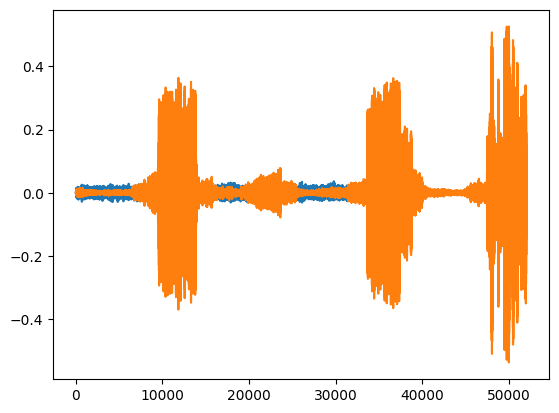

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
POS = os.path.join('/content/drive/MyDrive/Audio-classifier', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content/drive/MyDrive/Audio-classifier', 'Parsed_Not_Capuchinbird_Clips')

In [8]:
positive = tf.data.Dataset.list_files(POS+'/*.wav')
negative = tf.data.Dataset.list_files(NEG+'/*.wav')

In [9]:
positives = tf.data.Dataset.zip((positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
negatives = tf.data.Dataset.zip((negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))
data = positives.concatenate(negatives)

In [10]:
data.as_numpy_iterator().next()

(b'/content/drive/MyDrive/Audio-classifier/Parsed_Capuchinbird_Clips/XC46077-0.wav',
 1.0)

In [11]:
lengths = []
for file in os.listdir(POS):
  tensor_wave = wav_processor(os.path.join(POS, file))
  lengths.append(len(tensor_wave))

In [12]:
lengths_tensor = tf.constant(lengths, dtype=tf.float32)
tf.math.reduce_std(lengths_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=8172.87>

In [13]:
(54156 + (8172.87*1))

62328.87

In [14]:
def preprocessor(file_path, label):
  wav = wav_processor(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

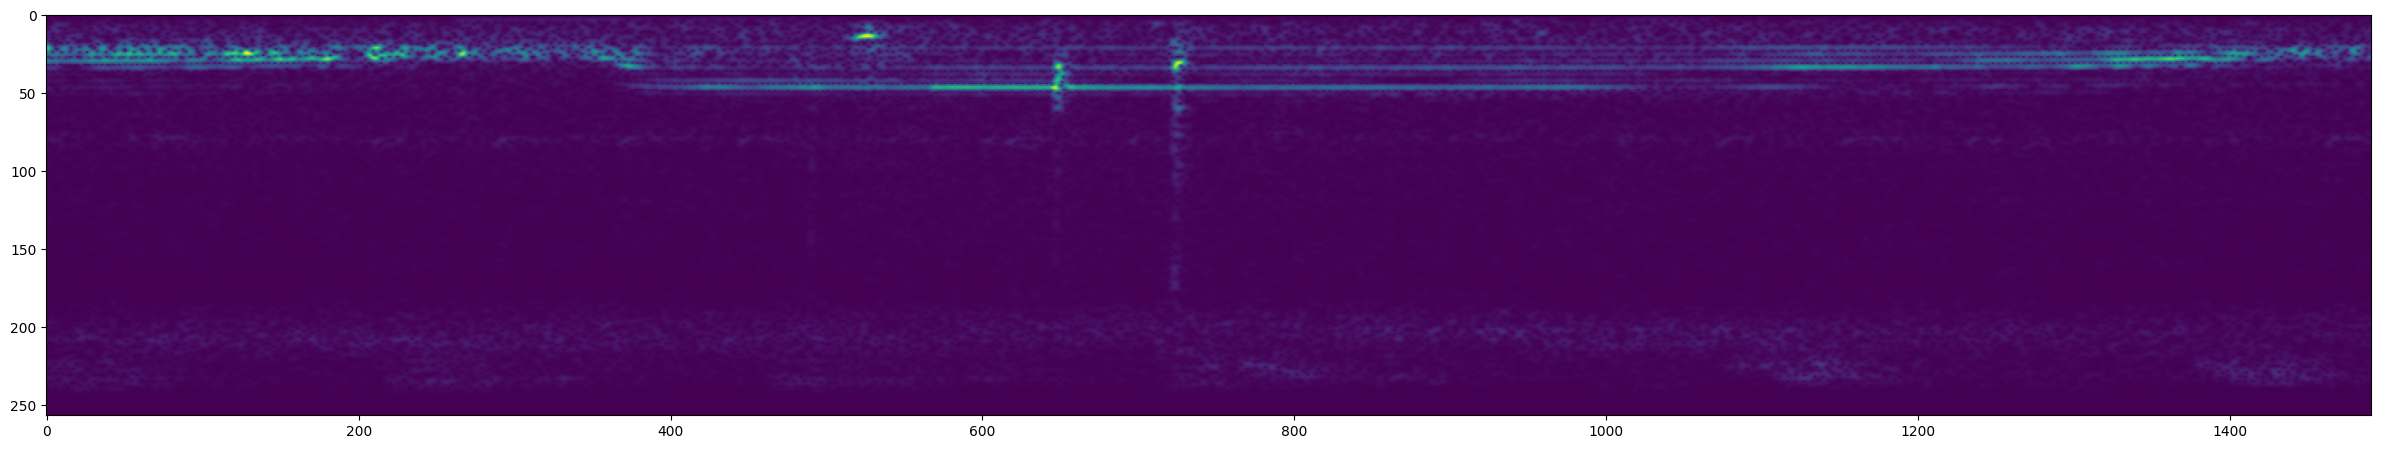

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocessor(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [16]:
data = data.map(preprocessor)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [17]:
len(data)*.8

40.800000000000004

In [18]:
train = data.take(40)
test = data.skip(40).take(11)

In [19]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [21]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 64)                385240128 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385,242,673
Trainable params: 385,242,673
Non-trainable params: 0
_________________________________________________________________


In [24]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
40/40 [==============================] - 16s 229ms/step - loss: 3.3869 - recall: 0.8802 - precision: 0.8400 - val_loss: 0.0666 - val_recall: 0.9362 - val_precision: 1.0000
Epoch 2/4
40/40 [==============================] - 8s 209ms/step - loss: 0.0253 - recall: 0.9706 - precision: 0.9940 - val_loss: 0.0328 - val_recall: 1.0000 - val_precision: 0.9796
Epoch 3/4
40/40 [==============================] - 9s 223ms/step - loss: 0.0153 - recall: 0.9890 - precision: 0.9890 - val_loss: 0.0020 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
40/40 [==============================] - 8s 208ms/step - loss: 0.0014 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0017 - val_recall: 1.0000 - val_precision: 1.0000


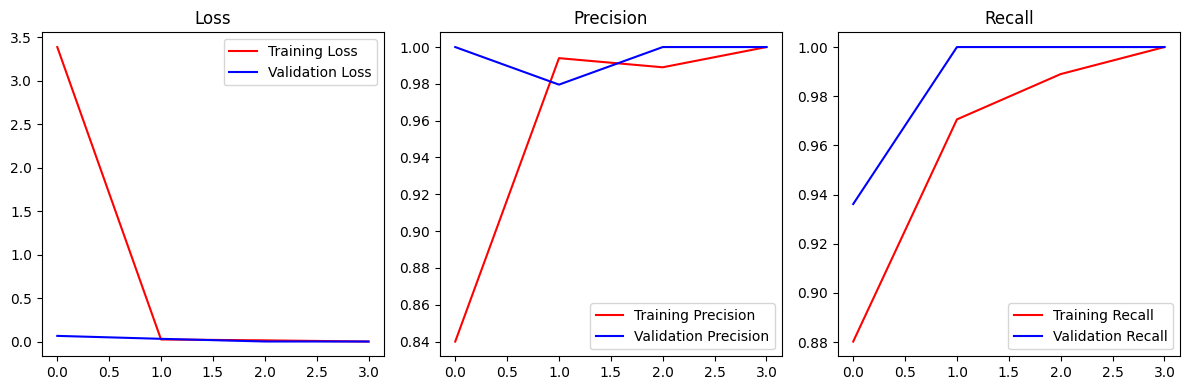

In [25]:
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label='Training Loss')
plt.plot(hist.history['val_loss'], 'b', label='Validation Loss')
plt.legend()

# Precision plot
plt.subplot(1, 3, 2)
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label='Training Precision')
plt.plot(hist.history['val_precision'], 'b', label='Validation Precision')
plt.legend()

# Recall plot
plt.subplot(1, 3, 3)
plt.title('Recall')
plt.plot(hist.history['recall'], 'r', label='Training Recall')
plt.plot(hist.history['val_recall'], 'b', label='Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 [==============================] - 0s 103ms/step


In [27]:
def mp3_loader(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [28]:
mp3 = os.path.join('/content/drive/MyDrive/Audio-classifier', 'Forest Recordings', 'recording_00.mp3')
wav = mp3_loader(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [29]:
def mp3_processor(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [30]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(mp3_processor)
audio_slices = audio_slices.batch(64)
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 9s 2s/step


In [31]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

5

In [32]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/Audio-classifier', 'Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/Audio-classifier','Forest Recordings', file)
    wav = mp3_loader(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(mp3_processor)
    audio_slices = audio_slices.batch(64)
    yhat = model.predict(audio_slices)
    results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [33]:
results

{'recording_00.mp3': array([[1.18108336e-02],
        [1.12084427e-03],
        [7.48042529e-03],
        [9.26591098e-01],
        [1.00000000e+00],
        [3.52037279e-03],
        [5.43861708e-04],
        [1.31748465e-03],
        [1.36541156e-03],
        [1.50639517e-02],
        [5.52299106e-03],
        [8.63342918e-03],
        [6.74884766e-04],
        [1.00000000e+00],
        [1.00000000e+00],
        [8.37338506e-04],
        [2.45927190e-09],
        [4.42177756e-03],
        [5.22191077e-03],
        [5.85315609e-03],
        [2.07984191e-03],
        [3.15029221e-03],
        [5.16502745e-02],
        [8.07443082e-01],
        [1.00000000e+00],
        [1.00278448e-04],
        [1.76473681e-04],
        [1.21648507e-02],
        [1.02599943e-03],
        [1.01930024e-02],
        [3.42715229e-03],
        [2.30711028e-02],
        [2.21107826e-02],
        [1.08440336e-05],
        [3.10853682e-02],
        [1.47185731e-03],
        [1.00000000e+00],
        [8.7926976

In [34]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.95 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [35]:
processed = {}
for file, scores in class_preds.items():
    processed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
processed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 22,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_14.mp3': 0,
 'recording_13.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 3,
 'recording_19.mp3': 1,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_25.mp3': 2,
 'recording_29.mp3': 6,
 'recording_28.mp3': 6,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 1,
 'recording_38.mp3': 2,
 'recording_37.mp3': 3,
 'recording_40.mp3': 1,
 'recording_42.mp3': 0,
 'recording_41.

In [36]:
with open('/content/drive/MyDrive/Audio-classifier/results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in processed.items():
        writer.writerow([key, value])

By: Amir Andikfar